In [29]:
import torch
import sys
import torch.onnx
import torch.utils
import torch.utils.data
import torch.nn.functional as F
import torch.nn as nn
from model import ResNet

device = torch.device("cuda:0")

columns = 3
rows = 3
channels = 16
layers = 5
epochs = 100
training_batch_size = 64
inference_batch_size = 256
kl_loss_scale = 0.1

data_folder = "../data"
models_folder = "../models"
generation = 1

class Snapshots(torch.utils.data.Dataset):
    def __init__(self, file_name):
        self.data = [[], [], [], []]
        i = 0
        with open(file_name) as f:
            for line in f.readlines():
                if line.strip() == "":
                    i = 0
                    continue

                t = torch.tensor([float(x) for x in line.split(", ")])

                if i == 0:
                    t = t.view(7, columns, rows)
                self.data[i].append(t)
                i += 1

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, index):
        return [self.data[x][index] for x in range(4)]

In [28]:
def loss_fn(wp_out, sp_out, vs_out, wp_label, sp_label, vs_label):
    kl_div = nn.KLDivLoss(reduction='sum')
    mse = nn.MSELoss(reduction='sum')
    
    # Concatenate the outputs to form the complete action distribution
    actions_out = torch.cat([wp_out, sp_out], dim=1)
    # Apply log_softmax to convert to log probabilities
    log_probs = F.log_softmax(actions_out, dim=1)
    
    # Concatenate the labels to form the complete target distribution
    actions_label = torch.cat([wp_label, sp_label], dim=1)
    
    # Compute the KL divergence loss
    kl_loss = kl_loss_scale * kl_div(log_probs, actions_label)
    
    # Compute the MSE loss for the scalar output
    mse_loss = mse(vs_out, vs_label)

    return (kl_loss, mse_loss)


def save_model(model, folder):
    torch.save(model, f"{folder}/model_{generation}.pt")
    input_names = ["States"]
    output_names = ["WallPriors", "StepPriors", "Values"]
    dummy_input = torch.randn(inference_batch_size, 7, columns, rows).to(device)
    torch.onnx.export(
        model,
        dummy_input,
        f"{folder}/model_{generation}.onnx",
        input_names=input_names,
        output_names=output_names,
    )

In [3]:
model = torch.load(f"{models_folder}/model_{generation - 1}.pt").to(device)

In [4]:
training_window = range((generation - 1) // 2, generation)
snapshots = torch.utils.data.ConcatDataset(
    [Snapshots(f"{data_folder}/snapshots_{i}.csv") for i in training_window]
)
training_data, eval_data = torch.utils.data.random_split(snapshots, [0.8, 0.2])
training_loader = torch.utils.data.DataLoader(
    training_data,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
eval_loader = torch.utils.data.DataLoader(
    eval_data,
    batch_size=training_batch_size,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.02)

In [5]:
import matplotlib.pyplot as plt

def plot_tensor(mat, cmap='viridis'):
    """
    Plots a 2D PyTorch tensor as an n x n grid of squares with colors representing the tensor values.

    Parameters:
    - mat: 2D PyTorch tensor of floats.
    - cmap: Colormap for visualizing the values in the tensor.
    """
    # Ensure mat is a 2D tensor
    if mat.dim() != 2:
        raise ValueError("Input tensor must be 2D")

    # Convert the tensor to a NumPy array
    matrix = mat.numpy()

    # Plotting the matrix
    plt.figure(figsize=(6,6))  # Adjust the figure size as needed
    plt.imshow(matrix, cmap=cmap, interpolation='nearest')  # Use specified colormap
    plt.colorbar()  # Show color scale
    plt.xticks(range(matrix.shape[0]))  # Adjust ticks based on tensor size
    plt.yticks(range(matrix.shape[1]))
    plt.grid(False)  # Turn off the grid
    plt.show()

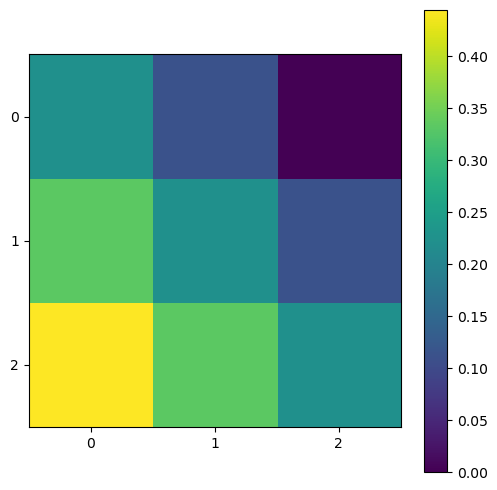

In [6]:
plot_tensor(snapshots[2][0][0])

In [7]:
snapshots[0]

[tensor([[[0.0000, 0.1111, 0.2222],
          [0.1111, 0.2222, 0.3333],
          [0.2222, 0.3333, 0.4444]],
 
         [[0.4444, 0.3333, 0.2222],
          [0.3333, 0.2222, 0.1111],
          [0.2222, 0.1111, 0.0000]],
 
         [[0.2222, 0.1111, 0.0000],
          [0.3333, 0.2222, 0.1111],
          [0.4444, 0.3333, 0.2222]],
 
         [[0.2222, 0.3333, 0.4444],
          [0.1111, 0.2222, 0.3333],
          [0.0000, 0.1111, 0.2222]],
 
         [[0.0000, 0.0000, 1.0000],
          [0.0000, 0.0000, 1.0000],
          [0.0000, 0.0000, 1.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]),
 tensor([0.0180, 0.0240, 0.0000, 0.0240, 0.0240, 0.0000, 0.0240, 0.0700, 0.0000,
         0.0300, 0.0240, 0.0240, 0.0240, 0.0240, 0.0240, 0.0000, 0.0000, 0.0000]),
 tensor([0.4700, 0.1960, 0.0000, 0.0000]),
 tensor([1.])]

In [31]:
kl_losses = []
mse_losses = []

try:
    for epoch in range(1000):
        for states, wall_priors, step_priors, values in training_loader:
            states = states.to(device)
            wall_priors = wall_priors.to(device)
            step_priors = step_priors.to(device)
            values = values.to(device)
    
            optimizer.zero_grad()
            wp, sp, vs = model.forward(states)
            loss = sum(loss_fn(wp, sp, vs, wall_priors, step_priors, values))
    
            loss.backward()
            optimizer.step()
            del loss
    
        model.train(False)
        total_kl_loss = 0
        total_mse_loss = 0
        for states, wall_priors, step_priors, values in eval_loader:
            states = states.to(device)
            wall_priors = wall_priors.to(device)
            step_priors = step_priors.to(device)
            values = values.to(device)
            wp, sp, vs = model.forward(states)
            kl_loss, mse_loss = loss_fn(wp, sp, vs, wall_priors, step_priors, values)
            total_kl_loss += float(kl_loss)
            total_mse_loss += float(mse_loss)
        kl_losses.append(total_kl_loss / len(eval_loader))
        mse_losses.append(total_mse_loss / len(eval_loader))
        print(
            f"Average loss in epoch {epoch} of generation {generation}: {total_kl_loss / len(eval_loader)} + {total_mse_loss / len(eval_loader)} = {(total_kl_loss + total_mse_loss) / len(eval_loader)}."
        )
except KeyboardInterrupt:
    print("Trainig was interrupted.")

Average loss in epoch 0 of generation 1: 6.561356283084562 + 4.8871760619718145 = 11.448532345056377.
Average loss in epoch 1 of generation 1: 6.558689236798406 + 5.055233400807158 = 11.613922637605565.
Average loss in epoch 2 of generation 1: 6.552462897495991 + 4.818212941879483 = 11.370675839375473.
Average loss in epoch 3 of generation 1: 6.58380699693133 + 5.726263093605854 = 12.310070090537184.
Average loss in epoch 4 of generation 1: 6.580648355156459 + 5.042597662938003 = 11.623246018094463.
Average loss in epoch 5 of generation 1: 6.57219272308652 + 4.893622975388008 = 11.465815698474527.
Average loss in epoch 6 of generation 1: 6.5676774232201725 + 5.062087929327794 = 11.629765352547967.
Average loss in epoch 7 of generation 1: 6.5627007720649955 + 4.9325783017634 = 11.495279073828396.
Average loss in epoch 8 of generation 1: 6.5601299905084085 + 5.041202742955801 = 11.60133273346421.
Trainig was interrupted.


In [34]:
initial_state = torch.unsqueeze(snapshots[0][0], 0).to(device)

In [35]:
model.forward(initial_state)

(tensor([[1.5199e-07, 1.0383e-12, 2.9369e-13, 1.0010e-07, 1.7205e-09, 2.9369e-13,
          1.3715e-08, 1.0499e-13, 2.9369e-13, 2.2141e-09, 2.2504e-06, 2.1463e-13,
          2.8910e-11, 1.6168e-11, 1.4175e-13, 2.9369e-13, 2.9369e-13, 2.9369e-13]],
        device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([[1.0000e+00, 9.9987e-01, 2.4577e-09, 2.3685e-10]], device='cuda:0',
        grad_fn=<SigmoidBackward0>),
 tensor([[0.9366]], device='cuda:0', grad_fn=<TanhBackward0>))

In [12]:
foo = []

In [13]:
foo.append(3)

In [14]:
foo

[3]

In [21]:
save_model(model, models_folder)

In [23]:
sum(1, 2)

TypeError: 'int' object is not iterable

In [24]:
sum((1, 2))

3

In [25]:
x, y = 1, 2

In [26]:
x, y += 3, 4

SyntaxError: 'tuple' is an illegal expression for augmented assignment (1979919024.py, line 1)